In [1]:
import sys
import os

# Add the parent directory to the system path
sys.path.append(os.path.abspath(os.path.join(os.path.abspath(''), '..')))
import flares

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cmasher as cmr
from matplotlib.colors import Normalize
from scipy.stats import binned_statistic
from unyt import erg, s

from synthesizer.grid import Grid
from synthesizer.emission_models.agn.models import DiscIncidentEmission
from synthesizer.particle import BlackHoles

from flares_utility import analyse
from flares_utility.stats import weighted_median, binned_weighted_quantile

# Set a random number seed to ensure consistent results
np.random.seed(42)

['00', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39']
['005_z010p000', '006_z009p000', '007_z008p000', '008_z007p000', '009_z006p000', '010_z005p000']
Galaxy
Galaxy/details
Galaxy/details/blackhole_accretion_rate
Galaxy/details/blackhole_accretion_rate/10
Galaxy/details/blackhole_accretion_rate/100
Galaxy/details/blackhole_accretion_rate/20
Galaxy/details/blackhole_accretion_rate/200
Galaxy/details/blackhole_accretion_rate/50
Galaxy/details/blackhole_accretion_rate/instant
Galaxy/details/blackhole_mass
Galaxy/master
Galaxy/master/attenuated_stellar_halpha_ew
Galaxy/master/attenuated_stellar_halpha_luminosity
Galaxy/master/blackhole_accretion_rate
Galaxy/master/blackhole_accretion_rate/instant
Galaxy/master/blackhole_id
Galaxy/master/blackhole_mass
Galaxy/master/intrinsic_stellar_halpha_ew
Galaxy/master

In [2]:
# filename='/Users/sw376/Dropbox/Research/data/simulations/flares/flares_no_particlesed.hdf5'
# flares = analyse.analyse(filename, default_tags=False)
# flares.list_datasets()

In [3]:
# set style
plt.style.use('../matplotlibrc.txt')

## get data

In [4]:
# # get data
# blackhole_mass, blackhole_accretion_rate, bolometric_luminosity, eddington_ratio, weights = u.load_all_blackhole_data()

# selection = (blackhole_mass.to('Msun').value > 1E6) & (bolometric_luminosity.to('erg/s').value > 1E44)

# blackhole_mass = blackhole_mass[selection]
# blackhole_accretion_rate = blackhole_accretion_rate[selection]
# bolometric_luminosity = bolometric_luminosity[selection]
# weights = weights[selection]

# conservative_selection = (blackhole_mass.to('Msun').value > 1E7) & (bolometric_luminosity.to('erg/s').value > 1E45)

# print(np.sum(conservative_selection))

# selection_label = r'$\rm M_{\bullet}>10^{6}\ M_{\odot}, L_{\rm bol}>10^{44}\ {\rm erg\ s^{-1}}$'
# conservative_selection_label = r'$\rm M_{\bullet}>10^{7}\ M_{\odot}, L_{\rm bol}>10^{45}\ {\rm erg\ s^{-1}}$'




tag = flares.tags[-1]
print(tag)
quantities = flares.get_quantities(tag, group='details')

blackhole_mass = quantities['blackhole_masses'].to('Msun')
blackhole_accretion_rate = quantities['accretion_rates']['10'].to('Msun/yr')
bolometric_luminosity = quantities['bolometric_luminosities']['10']
eddington_ratio = quantities['eddington_ratios']['10']
weights = quantities['weights']
stellar_halpha_luminosity = quantities['attenuated_stellar_halpha_luminosity'] * erg/s
intrinsic_stellar_halpha_luminosity = quantities['intrinsic_stellar_halpha_luminosity'] * erg/s

# print(blackhole_mass)
print('total number of BHs', len(blackhole_mass))

selection = (blackhole_mass.to('Msun').value > 1E6) & (bolometric_luminosity.to('erg/s').value > 1E44)

print(np.sum(selection))

stellar_halpha_luminosity = stellar_halpha_luminosity[selection]
intrinsic_stellar_halpha_luminosity = intrinsic_stellar_halpha_luminosity[selection]
blackhole_mass = blackhole_mass[selection]
blackhole_accretion_rate = blackhole_accretion_rate[selection]
bolometric_luminosity = bolometric_luminosity[selection]
weights = weights[selection]

conservative_selection = (blackhole_mass.to('Msun').value > 1E7) & (bolometric_luminosity.to('erg/s').value > 1E45)

print(np.sum(conservative_selection))


selection_label = r'$\rm M_{\bullet}>10^{6}\ M_{\odot}, L_{\rm bol}>10^{44}\ {\rm erg\ s^{-1}}$'
conservative_selection_label = r'$\rm M_{\bullet}>10^{7}\ M_{\odot}, L_{\rm bol}>10^{45}\ {\rm erg\ s^{-1}}$'





010_z005p000
total number of BHs 237437
785
153


First we need to initialise our `BlackHole` object with the parameters that will be needed to compute spectra.

In [5]:

blackholes = BlackHoles(
    masses=blackhole_mass,
    accretion_rates=blackhole_accretion_rate,
)

## Generating spectral energy distribution

We can generate spectra by passing a blackhole emission model (e.g. the `UnifiedAGN` model described in [emission_models](emission_models.ipynb)) to the spectra creation method (`get_intinsic_spectra`).

## Open the disc grid

In [6]:

grid_name = 'qsosed-isotropic'
grid_dir = "/Users/sw376/Dropbox/Research/data/synthesizer/grids/"

grid = Grid(
    grid_name=grid_name, 
    grid_dir=grid_dir,
    read_lines=False)

# Initialise the emission model

In [7]:

emission_model = DiscIncidentEmission(grid)


### Generate spectra 

In [8]:
# get the spectra assuming this emission model
blackholes.get_particle_spectra(emission_model)

# shorthand
spectra = blackholes.particle_spectra['disc_incident']

In [9]:
from unyt import Msun, G, mp, sigma_thompson, c

radiative_efficiency = 0.1

theory_blackhole_masses = 10**np.arange(6., 9.5, 0.01) * Msun

theory_accretion_rates_eddington = ((4 * np.pi * G * theory_blackhole_masses * mp)
            / (radiative_efficiency * sigma_thompson * c))



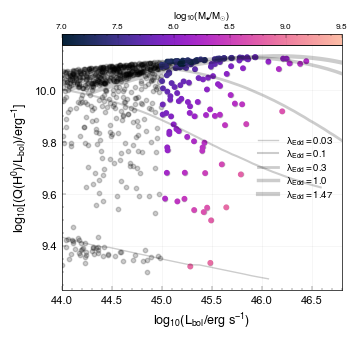

In [10]:
ionising_photon_luminosity = spectra.calculate_ionising_photon_production_rate()

ionising_bolometric_correction = ionising_photon_luminosity/spectra.bolometric_luminosity




xlimits = [44.5, 46.8] # Msun
ylimits = np.array([-2.8, 0.4])
 

fig = plt.figure(figsize = (3.5, 3.5))

left  = 0.15
height = 0.7
bottom = 0.15
width = 0.8
hwidth = 0.2

ax = fig.add_axes((left, bottom, width, height))
cax = fig.add_axes([left, bottom+height, width, 0.03])



for i, eddington_rate in enumerate([0.03, 0.1, 0.3, 1., 1.47]):

    theory_blackholes = BlackHoles(
        masses=theory_blackhole_masses,
        accretion_rates=eddington_rate*theory_accretion_rates_eddington,
    )

    # get the spectra assuming this emission model
    theory_blackholes.get_particle_spectra(emission_model)

    # shorthand
    theory_spectra = theory_blackholes.particle_spectra['disc_incident']

    theory_ionising_photon_luminosity = theory_spectra.calculate_ionising_photon_production_rate()

    theory_ionising_bolometric_correction = theory_ionising_photon_luminosity/theory_spectra.bolometric_luminosity

    # add line for constant eddington accretion rate
    ax.plot(np.log10(theory_blackholes.bolometric_luminosity.to('erg/s').value),
            np.log10(theory_ionising_bolometric_correction.to('1/erg').value),
            lw=1+i/2,
            c='k',
            alpha=0.2,
            label=rf'$\rm \lambda_{{Edd}}={eddington_rate}$')


norm = Normalize(vmin=7., vmax=9.5)
cmap = cmr.bubblegum
n = norm

# ax.axhline(-1.5, c='k', lw=1, alpha=0.5)
# ax.fill_between(xlimits,[-10,-10],[-1.5, -1.5], color='k', alpha=0.05)
# ax.fill_between([42., 45.],[-10,-10],[0.5, 0.5], hatch='///', color='0.7')

# Let's plot!
ax.scatter(np.log10(blackholes.bolometric_luminosity.to('erg/s').value),
           np.log10(ionising_bolometric_correction.to('1/erg').value),
           s=10,
           zorder=1,
           c='k',
           alpha=0.2)

ax.scatter(np.log10(blackholes.bolometric_luminosity.to('erg/s').value[conservative_selection]),
           np.log10(ionising_bolometric_correction.to('1/erg').value[conservative_selection]),
           s=10,
           zorder=1,
           c=cmap(norm(np.log10(blackholes.masses.to('Msun').value[conservative_selection]))))

ax.set_xlim(xlimits)
# ax.set_ylim(ylimits)
# ax.set_yscale('log')

ax.set_xlabel(r'$\rm log_{10}(L_{bol}/erg\ s^{-1})$')
ax.set_ylabel(r'$\rm log_{10}[(Q(H^0)/L_{bol})/erg^{-1}]$')

ax.legend(fontsize=7, labelspacing=0.1, loc='center right')

# add colourbar
cmapper = cm.ScalarMappable(norm=norm, cmap=cmap)
fig.colorbar(cmapper, cax=cax, orientation='horizontal')
cax.xaxis.tick_top()
cax.xaxis.set_label_position('top')
cax.set_xlabel(r'$\rm log_{10}(M_{\bullet}/M_{\odot})$', fontsize=7)
cax.tick_params(axis='x', labelsize=6)

# ax.set_yticks([9.5,])
ax.set_xticks([44., 44.5, 45., 45.5, 46., 46.5])

filename = f'figures/bolometric_luminosity-ionising_photon_luminosity.pdf'
fig.savefig(filename)
plt.show()
fig.clf()



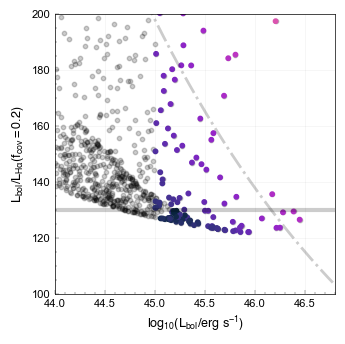

In [12]:
ionising_photon_luminosity = spectra.calculate_ionising_photon_production_rate()

ionising_bolometric_correction = ionising_photon_luminosity/spectra.bolometric_luminosity

Halpha_bolometric_correction = 1/(ionising_bolometric_correction * flares.ionising_to_Halpha_conversion)


xlimits = [44.5, 46.8] 
ylimits = [100, 200] 
 
fig = plt.figure(figsize = (3.5, 3.5))

left  = 0.15
height = 0.8
bottom = 0.15
width = 0.8

ax = fig.add_axes((left, bottom, width, height))

norm = Normalize(vmin=7., vmax=9.5)
cmap = cmr.bubblegum
n = norm

# ax.axhline(-1.5, c='k', lw=1, alpha=0.5)
# ax.fill_between(xlimits,[-10,-10],[-1.5, -1.5], color='k', alpha=0.05)
# ax.fill_between([42., 45.],[-10,-10],[0.5, 0.5], hatch='///', color='0.7')



# used by 
ax.axhline(130, c='k', alpha=0.2, lw=3)


# used by matthee

halpha_luminosity = 10**np.arange(41, 46, 0.1)

bolometric_luminosity = 1E44 * 10.33 * (halpha_luminosity/(5.25E42))**(1/1.157)


ax.plot(np.log10(bolometric_luminosity), bolometric_luminosity/halpha_luminosity, c='k', alpha=0.2, lw=2, ls='-.')


f_cov = 0.2

# Let's plot!
ax.scatter(np.log10(blackholes.bolometric_luminosity.to('erg/s').value),
           Halpha_bolometric_correction.value/f_cov,
           s=10,
           zorder=1,
           c='k',
           alpha=0.2)

ax.scatter(np.log10(blackholes.bolometric_luminosity.to('erg/s').value[conservative_selection]),
           Halpha_bolometric_correction.value[conservative_selection]/f_cov,
           s=10,
           zorder=1,
           c=cmap(norm(np.log10(blackholes.masses.to('Msun').value[conservative_selection]))))

ax.set_xlim(xlimits)
ax.set_ylim(ylimits)
# ax.set_yscale('log')

ax.set_xlabel(r'$\rm log_{10}(L_{bol}/erg\ s^{-1})$')
ax.set_ylabel(r'$\rm L_{\rm bol}/L_{\rm H\alpha}(f_{cov}=0.2)$')

ax.legend(fontsize=7, labelspacing=0.1, loc='center right')

# ax.set_yticks([9.5,])
ax.set_xticks([44., 44.5, 45., 45.5, 46., 46.5])

filename = f'figures/bolometric_luminosity-Halpha_photon_luminosity.pdf'
fig.savefig(filename)
plt.show()
fig.clf()
